<a href="https://colab.research.google.com/github/joebathelt/AUC_Neuroimaging/blob/main/MindReading_Week5_solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Function to install nilearn - Please run this first
!pip install nilearn

# The BOLD Signal and the General Linear Model (GLM)

In this lab, we apply the **General Linear Model (GLM)** to functional MRI data. The lecture introduced the conceptual logic of the GLM — how experimental designs generate predictions about brain activity, and how those predictions are tested against observed BOLD signals. This session provides hands-on experience with the computational steps involved.

By the end of this session, you should be able to:

1. Explain what the dependent variable and predictors represent in an fMRI GLM.
2. Describe why convolution with the haemodynamic response function (HRF) is necessary.
3. Construct convolved predictors from stimulus onset information and interpret the parameters estimated by the GLM.

**Estimated time to complete:** 1.5 hour

In [ ]:
# Please run this cell to download the required data for this tutorial
import os
import urllib.request

def download_file(url, outfile):
    """Download file from URL if not already present."""
    if not os.path.exists(outfile):
        print(f"Downloading {outfile}...")
        urllib.request.urlretrieve(url, outfile)
        print(f"Saved as {outfile}")
    else:
        print(f"{outfile} already exists, skipping download.")

# Downloading some required data
download_file(
    "https://www.dropbox.com/scl/fi/euhf1knahdgweee55tgq8/example_voxel_signal.npy?rlkey=gus2nuki9mgd3mqfepdjeksyj&dl=1",
    "example_voxel_signal.npy"
)

example_voxel_signal.npy already exists, skipping download.


### 1.1 The Dependent Variable: A Voxel Time Series

In a conventional regression analysis, the dependent variable ($y$) might represent a behavioural outcome such as reaction time or accuracy. In the fMRI GLM, $y$ is the **time series of a single voxel** — the sequence of BOLD signal values measured at each volume acquisition across the duration of the experiment.

Each data point in $y$ corresponds to one volume (i.e., one TR), and the total number of observations ($N$) equals the number of volumes acquired. A participant scanned for 800 seconds with a TR of 2 seconds, for example, would yield a time series of 400 data points.

Let us load and visualise an example voxel time series from a visual perception experiment.

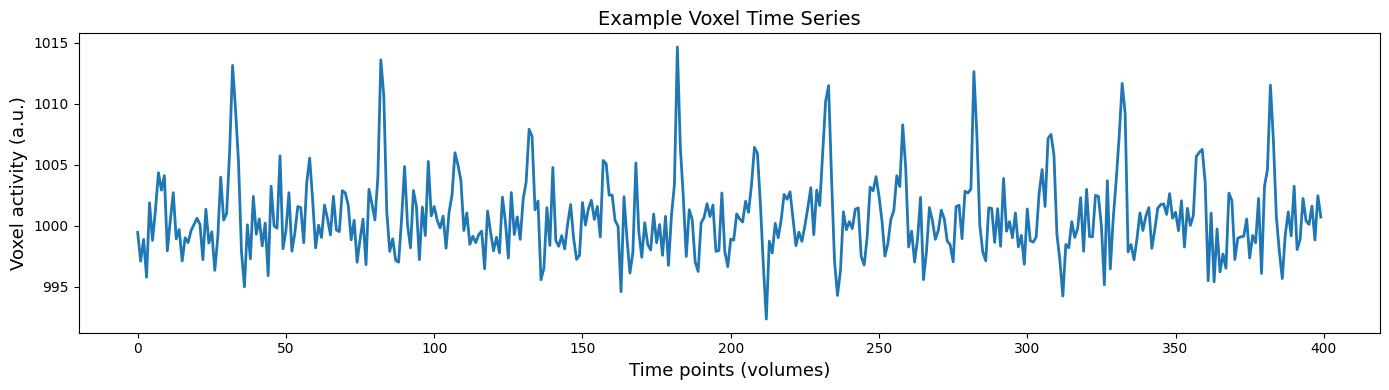

Number of volumes (N): 400
With TR = 2s, experiment duration = 800 seconds


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Load and plot an example voxel time series
voxel_signal = np.load("example_voxel_signal.npy")

plt.figure(figsize=(14, 4))
plt.plot(voxel_signal, color="tab:blue", linewidth=2)
plt.xlabel("Time points (volumes)", fontsize=13)
plt.ylabel("Voxel activity (a.u.)", fontsize=13)
plt.title("Example Voxel Time Series", fontsize=14)
plt.tight_layout()
plt.show()

print(f"Number of volumes (N): {voxel_signal.size}")
print(f"With TR = 2s, experiment duration = {voxel_signal.size * 2} seconds")

The signal fluctuates around a baseline of roughly 1000 arbitrary units. These fluctuations reflect a mixture of neural responses to the experimental stimuli, physiological noise (e.g., cardiac and respiratory cycles), scanner drift, and thermal noise. The challenge of the GLM is to isolate the stimulus-related component from this mixture – we'll cover further methods to deal with this noise in the week about preprocessing.

A critical point to note: the GLM is applied **independently to each voxel** in the brain. The same model is fitted thousands of times — once per voxel — to produce a whole-brain map of parameter estimates.

### 1.2 The Predictors: Stimulus Events

The predictors in an fMRI GLM (the columns of the design matrix, $X$) are derived from the experimental design. In this example, participants viewed two types of visual stimuli — **squares** and **circles** — presented at known time points during the scan.

The first step in building a predictor is to represent the stimulus timing as a binary vector: a value of 1 at each time point when a stimulus was presented, and 0 otherwise. Because stimulus onsets are typically recorded in seconds (or milliseconds), this vector is initially constructed on a seconds-level time scale.

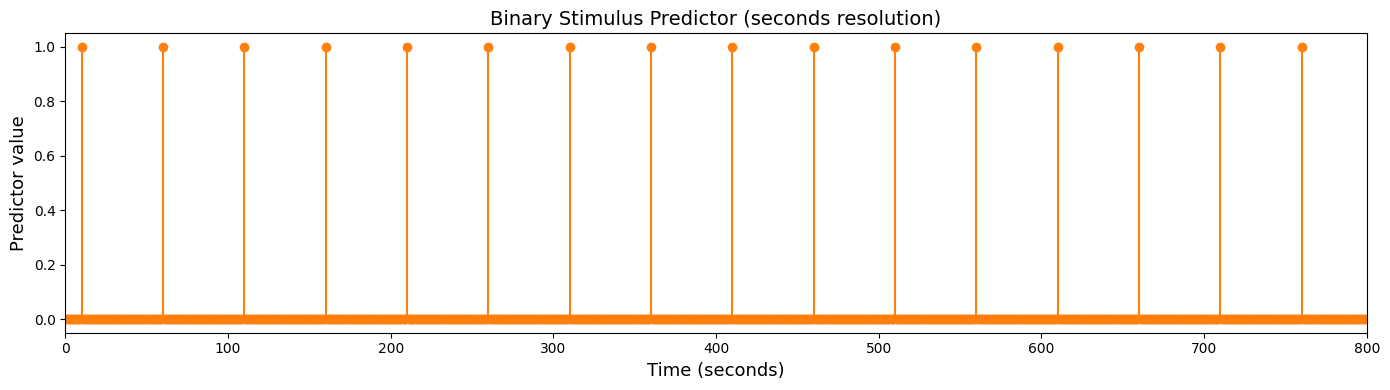

In [ ]:
# Define stimulus onsets (in seconds)
onsets_squares = np.array([10, 110, 210, 310, 410, 510, 610, 710], dtype=int)
onsets_circles = np.array([60, 160, 260, 360, 460, 560, 660, 760], dtype=int)

# For now, combine both conditions into a single predictor
onsets_all = np.concatenate((onsets_squares, onsets_circles))

# Create a binary stimulus vector at seconds resolution (800 time points)
predictor_all = np.zeros(800, dtype=int)
predictor_all[onsets_all] = 1

# Visualise
plt.figure(figsize=(14, 4))
plt.stem(range(len(predictor_all)), predictor_all,
         basefmt=" ", linefmt="tab:orange", markerfmt="o", label="Stimulus onsets")
plt.xlabel("Time (seconds)", fontsize=13)
plt.ylabel("Predictor value", fontsize=13)
plt.title("Binary Stimulus Predictor (seconds resolution)", fontsize=14)
plt.xlim(0, 800)
plt.tight_layout()
plt.show()

#### Resampling to Match the Voxel Time Series

The predictor above has 800 values (one per second), but the voxel signal has only 400 values (one per TR of 2 seconds). Before the predictor can serve as a column in the design matrix, both arrays must share the same length. This alignment is achieved through **resampling** (sometimes called downsampling) — selecting every second value to match the TR grid.

In [ ]:
from scipy.interpolate import interp1d

# Resample the predictor from seconds to TR (every 2 seconds)
original_scale = np.arange(0, 800, 1)          # 800 points, 1 per second
desired_scale = np.arange(0, 800, 2)            # 400 points, 1 per TR

resampler = interp1d(original_scale, predictor_all)
predictor_all_ds = resampler(desired_scale)

print(f"Original predictor length: {predictor_all.size} (seconds)")
print(f"Resampled predictor length: {predictor_all_ds.size} (volumes)")
print(f"Voxel signal length: {voxel_signal.size} (volumes)")

Original predictor length: 800 (seconds)
Resampled predictor length: 400 (volumes)
Voxel signal length: 400 (volumes)


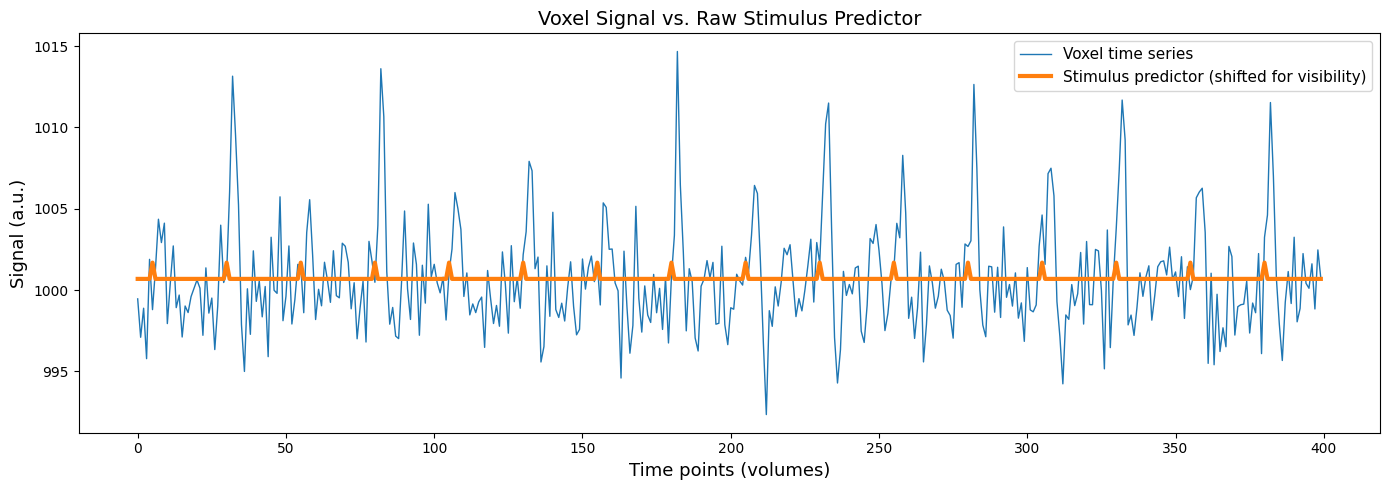

In [ ]:
# Overlay predictor and voxel signal
plt.figure(figsize=(14, 5))
plt.plot(voxel_signal, color="tab:blue", label="Voxel time series", linewidth=1)
plt.plot(predictor_all_ds + voxel_signal.mean(), color="tab:orange",
         linewidth=3, label="Stimulus predictor (shifted for visibility)")
plt.xlabel("Time points (volumes)", fontsize=13)
plt.ylabel("Signal (a.u.)", fontsize=13)
plt.title("Voxel Signal vs. Raw Stimulus Predictor", fontsize=14)
plt.legend(fontsize=11)
plt.tight_layout()
plt.show()

The sharp, instantaneous spikes of the binary predictor look nothing like the smooth, gradual fluctuations in the BOLD signal. This mismatch is expected: the raw predictor assumes that neural events produce immediate, instantaneous changes in the measured signal. In reality, the BOLD response unfolds over several seconds, which is why a critical additional step — **convolution with the haemodynamic response function** — is required.

### 1.3 The Haemodynamic Response Function (HRF)

The BOLD signal does not directly measure neural activity. Instead, it reflects changes in the ratio of oxygenated to deoxygenated haemoglobin in the local vasculature, which is rather sluggish compared to the underlying neural activity. After a brief neural event, the BOLD response typically peaks approximately 5–6 seconds later and returns to baseline after roughly 15–20 seconds, often dipping slightly below baseline before settling (the so-called "post-stimulus undershoot").

This stereotypical response profile is captured by the **canonical haemodynamic response function (HRF)**, a mathematical function that describes the expected BOLD response to a single, brief neural event. The most widely used version is the "double-gamma" HRF, which models both the primary peak and the undershoot.

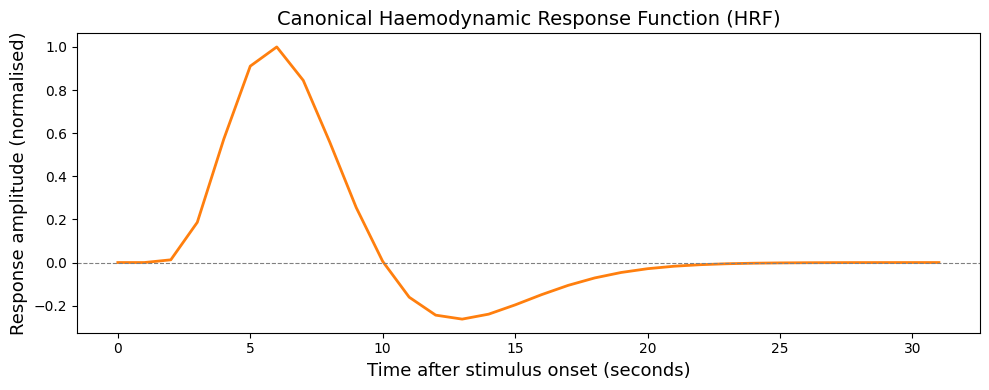

In [ ]:
from nilearn.glm.first_level.hemodynamic_models import glover_hrf

# Generate the canonical HRF
TR = 2
canonical_hrf = glover_hrf(t_r=TR, oversampling=2, time_length=32)
canonical_hrf /= canonical_hrf.max()  # normalise so the peak = 1

# Time axis in seconds
t = np.arange(canonical_hrf.size) * (TR / 2)  # accounting for oversampling

plt.figure(figsize=(10, 4))
plt.plot(t, canonical_hrf, color="tab:orange", linewidth=2)
plt.axhline(0, color="grey", linestyle="--", linewidth=0.8)
plt.xlabel("Time after stimulus onset (seconds)", fontsize=13)
plt.ylabel("Response amplitude (normalised)", fontsize=13)
plt.title("Canonical Haemodynamic Response Function (HRF)", fontsize=14)
plt.tight_layout()
plt.show()

As you can see in the plot above, the double-gamma HRF response peaks at approximately 5 seconds after stimulus onset. There is also a post-stimulus undershoot, visible as the small dip below zero around 10–18 seconds. Together, these features mean that the relationship between neural events and the measured BOLD signal is not a simple one-to-one mapping; rather, the HRF acts as a temporal filter that "smears" neural events across time.

### 1.4 Convolution: Building a Realistic Predictor

Given that each neural event produces not an instantaneous spike but a prolonged, HRF-shaped BOLD response, the binary stimulus vector must be transformed accordingly. The mathematical operation that achieves this is **convolution**.

Convolution can be understood intuitively as "stamping" a copy of the HRF at each stimulus onset, and then summing all the overlapping responses. The result is a continuous predictor that reflects what the BOLD signal *should* look like if the voxel responds to the experimental stimuli — capturing the lag, the gradual rise and fall, and the overlap between successive events.

Let us first demonstrate convolution with a small example — three events spaced 30 time points apart — before applying it to our actual experimental data.

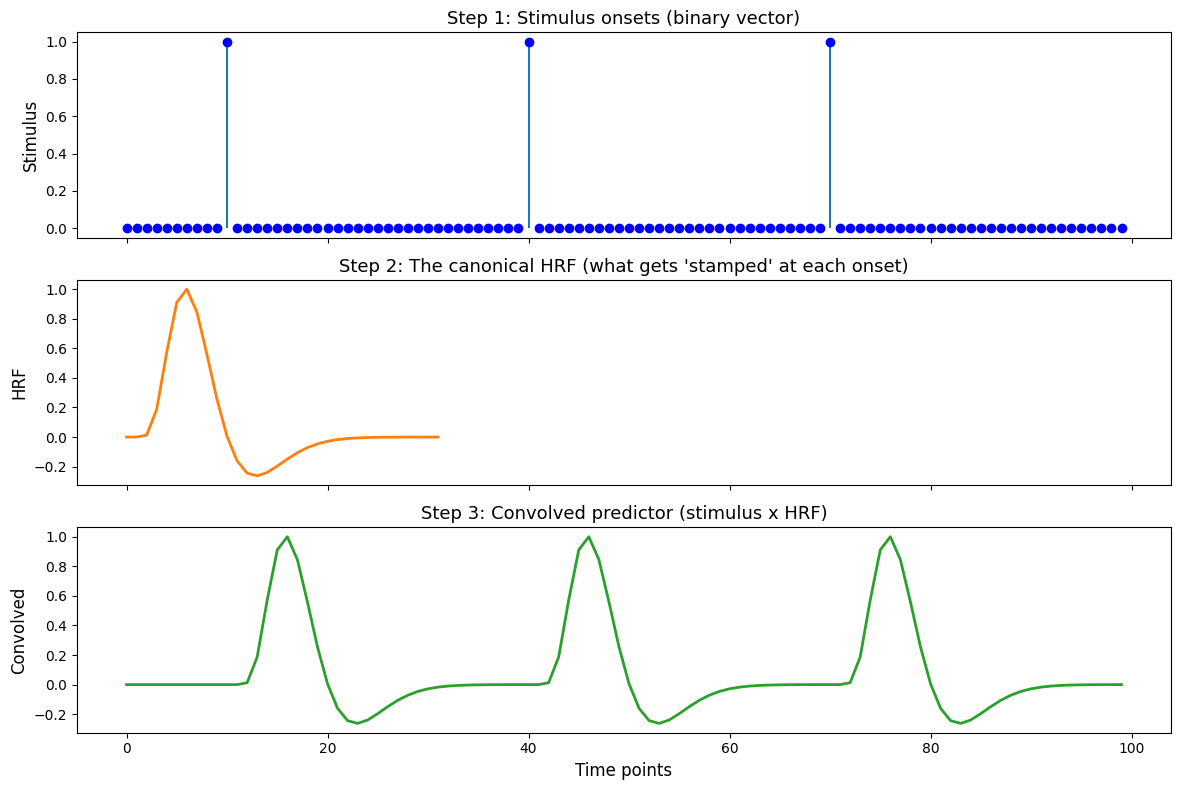

In [ ]:
# Demonstration: convolving a simple stimulus vector with the HRF
demo_stim = np.zeros(100)
demo_stim[[10, 40, 70]] = 1

demo_conv = np.convolve(demo_stim, canonical_hrf)[:100]  # trim to original length

fig, axes = plt.subplots(3, 1, figsize=(12, 8), sharex=True)

# Panel 1: stimulus onsets
axes[0].stem(range(100), demo_stim, basefmt=" ", linefmt="tab:blue", markerfmt="bo")
axes[0].set_ylabel("Stimulus", fontsize=12)
axes[0].set_title("Step 1: Stimulus onsets (binary vector)", fontsize=13)

# Panel 2: the HRF (shown once for reference)
axes[1].plot(canonical_hrf, color="tab:orange", linewidth=2)
axes[1].set_ylabel("HRF", fontsize=12)
axes[1].set_title("Step 2: The canonical HRF (what gets 'stamped' at each onset)", fontsize=13)

# Panel 3: result of convolution
axes[2].plot(demo_conv, color="tab:green", linewidth=2)
axes[2].set_ylabel("Convolved", fontsize=12)
axes[2].set_xlabel("Time points", fontsize=12)
axes[2].set_title("Step 3: Convolved predictor (stimulus x HRF)", fontsize=13)

plt.tight_layout()
plt.show()

The convolved predictor in the bottom panel now reflects the expected shape of the BOLD signal: a gradual rise after each event onset, a peak approximately 5 seconds later, and a return to baseline. When events are closely spaced, the individual responses overlap and sum. This summing is known as **linear superposition**, which is one of the fundamental assumptions of the standard fMRI GLM.

An important consequence of linear superposition is that the predicted BOLD response scales with stimulus duration. A stimulus lasting 15 seconds, for instance, produces a broader and more sustained response than a brief event, because the HRF is "stamped" at each second the stimulus is present and the resulting responses accumulate.

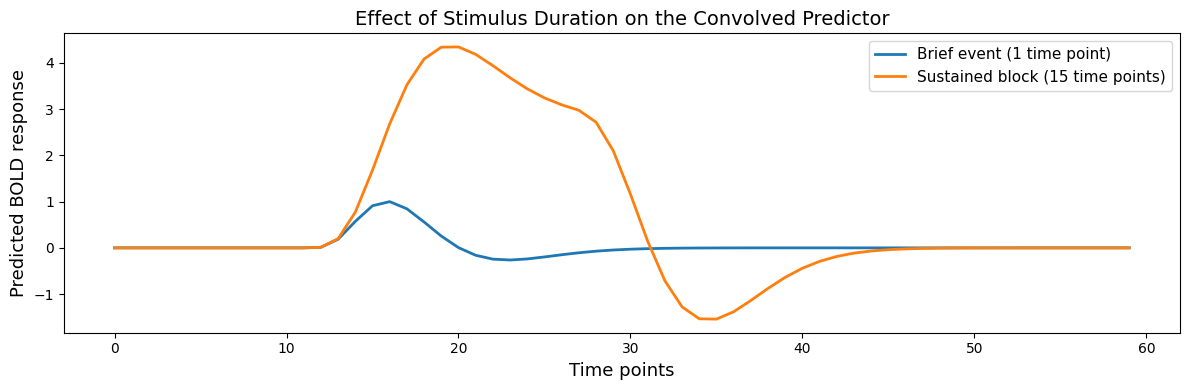

In [ ]:
# Demonstration: effect of stimulus duration on the convolved predictor
N = 60
brief_stim = np.zeros(N);   brief_stim[10] = 1
long_stim = np.zeros(N);    long_stim[10:25] = 1   # 15 time-point block

brief_conv = np.convolve(brief_stim, canonical_hrf)[:N]
long_conv = np.convolve(long_stim, canonical_hrf)[:N]

plt.figure(figsize=(12, 4))
plt.plot(brief_conv, label="Brief event (1 time point)", linewidth=2)
plt.plot(long_conv, label="Sustained block (15 time points)", linewidth=2)
plt.xlabel("Time points", fontsize=13)
plt.ylabel("Predicted BOLD response", fontsize=13)
plt.title("Effect of Stimulus Duration on the Convolved Predictor", fontsize=14)
plt.legend(fontsize=11)
plt.tight_layout()
plt.show()

### 1.5 Applying Convolution to Our Experimental Data

We now convolve the full stimulus vector from our experiment with the canonical HRF, and then resample the result to match the TR grid of the voxel signal. These two steps — convolution followed by resampling — are the standard procedure for transforming raw stimulus timing information into a physiologically informed predictor.

In [ ]:
# Convolve the stimulus predictor with the HRF
predictor_conv = np.convolve(predictor_all.squeeze(), canonical_hrf)
predictor_conv = predictor_conv[:800]  # trim to experiment duration

# Resample to TR grid
original_scale = np.arange(0, 800)
desired_scale = np.arange(0, 800, 2)
resampler = interp1d(original_scale, predictor_conv.squeeze(), kind="linear")
predictor_conv_ds = resampler(desired_scale)

print(f"Convolved predictor shape (after resampling): {predictor_conv_ds.shape}")
print(f"Voxel signal shape: {voxel_signal.shape}")

Convolved predictor shape (after resampling): (400,)
Voxel signal shape: (400,)


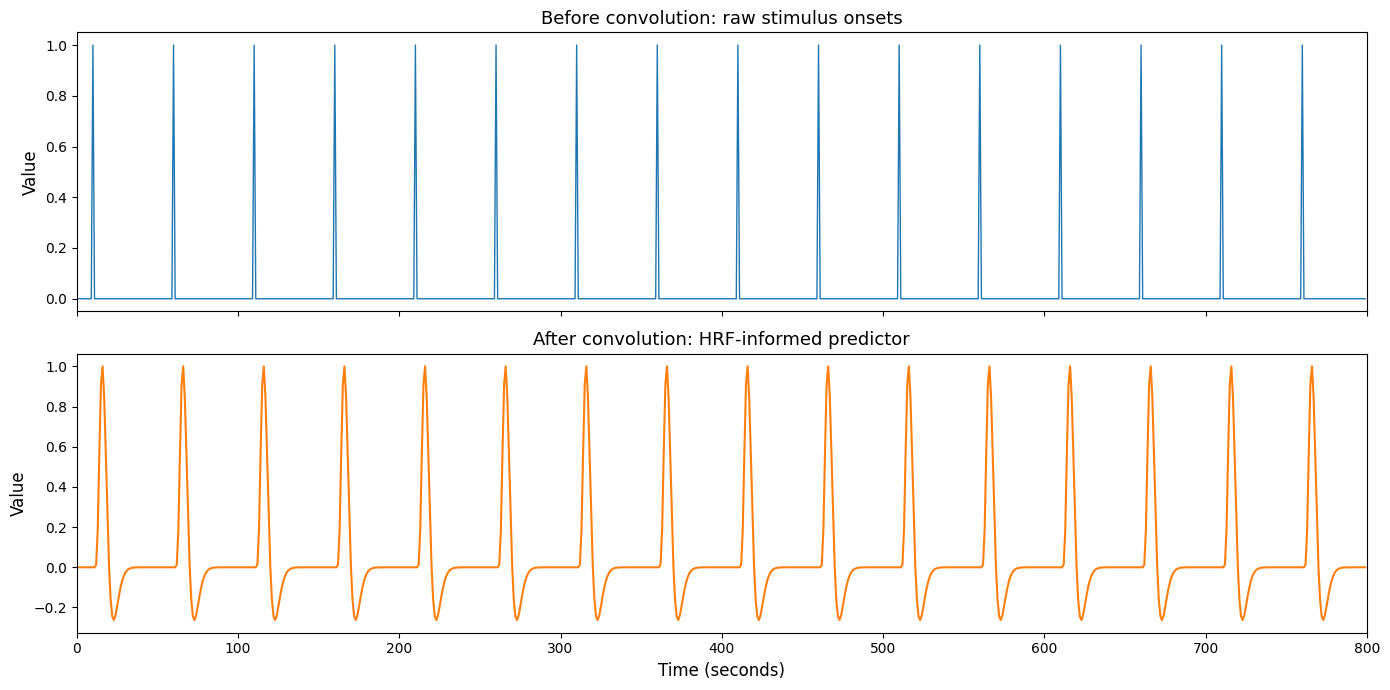

In [ ]:
# Compare the predictor before and after convolution
fig, axes = plt.subplots(2, 1, figsize=(14, 7), sharex=True)

axes[0].plot(predictor_all, color="tab:blue", linewidth=1)
axes[0].set_ylabel("Value", fontsize=12)
axes[0].set_title("Before convolution: raw stimulus onsets", fontsize=13)
axes[0].set_xlim(0, 800)

axes[1].plot(predictor_conv, color="tab:orange", linewidth=1.5)
axes[1].set_ylabel("Value", fontsize=12)
axes[1].set_xlabel("Time (seconds)", fontsize=12)
axes[1].set_title("After convolution: HRF-informed predictor", fontsize=13)
axes[1].set_xlim(0, 800)

plt.tight_layout()
plt.show()

### 1.6 Fitting the GLM and Interpreting Parameters

With a predictor that now matches both the length and the expected temporal shape of the voxel signal, we can fit the GLM. This involves constructing the **design matrix** ($X$) and estimating the **parameters** ($\hat{\beta}$) that best predict the observed signal.

The design matrix always includes at least two columns: the **convolved predictor** (representing the experimental manipulation) and an **intercept** (a column of ones, which captures the baseline signal level). Additional predictors for different experimental conditions can be included as separate columns.

The parameters are estimated using **Ordinary Least Squares (OLS)**, which finds the set of $\beta$ values that minimises the sum of squared differences between the observed signal ($y$) and the predicted signal ($\hat{y} = X\hat{\beta}$). The closed-form solution is:

$$\hat{\beta} = (X^TX)^{-1}X^Ty$$

Let us first fit a model with a single predictor (all stimuli combined) — without HRF convolution — and then compare it to the HRF-convolved version.

In [ ]:
from numpy.linalg import inv

def fit_glm(X, y):
    """Fit a GLM using OLS. Returns betas, predicted signal, R², and MSE."""
    betas = inv(X.T @ X) @ X.T @ y
    y_hat = X @ betas
    ss_res = np.sum((y - y_hat) ** 2)
    ss_tot = np.sum((y - y.mean()) ** 2)
    r2 = 1 - ss_res / ss_tot
    mse = np.mean((y - y_hat) ** 2)
    return betas, y_hat, r2, mse


# --- Model 1: raw (unconvolved) predictor ---
intercept = np.ones((400, 1))
X_raw = np.hstack([intercept, predictor_all_ds.reshape(-1, 1)])

betas_raw, y_hat_raw, r2_raw, mse_raw = fit_glm(X_raw, voxel_signal)

print("=== Model 1: Raw predictor (no HRF convolution) ===")
print(f"  Intercept (β₀):   {betas_raw[0]:.3f}")
print(f"  Stimulus (β₁):    {betas_raw[1]:.3f}")
print(f"  R²:               {r2_raw:.4f}")
print(f"  MSE:              {mse_raw:.2f}")


# --- Model 2: HRF-convolved predictor ---
X_conv = np.hstack([intercept, predictor_conv_ds.reshape(-1, 1)])

betas_conv, y_hat_conv, r2_conv, mse_conv = fit_glm(X_conv, voxel_signal)

print(f"\n=== Model 2: HRF-convolved predictor ===")
print(f"  Intercept (β₀):   {betas_conv[0]:.3f}")
print(f"  Stimulus (β₁):    {betas_conv[1]:.3f}")
print(f"  R²:               {r2_conv:.4f}")
print(f"  MSE:              {mse_conv:.2f}")

=== Model 1: Raw predictor (no HRF convolution) ===
  Intercept (β₀):   1000.647
  Stimulus (β₁):    1.023
  R²:               0.0039
  MSE:              10.33

=== Model 2: HRF-convolved predictor ===
  Intercept (β₀):   1000.232
  Stimulus (β₁):    8.124
  R²:               0.4345
  MSE:              5.86


The improvement is immediately visible. The raw predictor (top panel) produces a nearly flat predicted signal — it captures almost none of the variance in the voxel time series ($R^2 \approx 0.004$). By contrast, the HRF-convolved predictor (bottom panel) tracks the slow fluctuations in the signal far more closely, yielding a substantially higher $R^2$.

The estimated parameters have straightforward interpretations:

- **$\hat{\beta}_0$ (intercept)**: The baseline signal level — the predicted voxel activity when no stimulus is present. In fMRI, this is typically a large number (around 1000 arbitrary units) reflecting the steady-state magnetisation of the tissue.

- **$\hat{\beta}_1$ (stimulus)**: The amplitude of the BOLD response to the stimulus. This value represents how much the signal increases (or decreases) from baseline when the predictor has a value of 1. It is common to express this as a **percent signal change** relative to baseline: $(\hat{\beta}_1 / \hat{\beta}_0) \times 100$. In typical fMRI experiments, percent signal change values on the order of 0.5–2% are common for sensory stimuli.

### 1.7 Modelling Multiple Conditions

The model above combined squares and circles into a single predictor, which can only test whether the voxel responds to *any* stimulus. In most experiments, however, the scientific question concerns differences *between* conditions, e.g. does this voxel respond more strongly to squares than to circles?

To address such questions, the design matrix must include **separate predictors for each condition**. Each predictor is constructed from its own set of onsets, convolved independently with the HRF, and entered as a separate column in $X$. The resulting $\beta$ parameters then reflect the estimated response amplitude for each condition separately.

In [ ]:
# Build separate predictors for circles and squares
predictor_circles = np.zeros(800)
predictor_circles[onsets_circles] = 1

predictor_squares = np.zeros(800)
predictor_squares[onsets_squares] = 1

# Convolve each with the HRF
conv_circles = np.convolve(predictor_circles, canonical_hrf)[:800]
conv_squares = np.convolve(predictor_squares, canonical_hrf)[:800]

# Resample both to TR grid
original_scale = np.arange(0, 800)
desired_scale = np.arange(0, 800, 2)

conv_circles_ds = interp1d(original_scale, conv_circles)(desired_scale)
conv_squares_ds = interp1d(original_scale, conv_squares)(desired_scale)

# Build design matrix: [intercept, circles, squares]
X_sep = np.column_stack([
    np.ones(400),
    conv_circles_ds,
    conv_squares_ds
])

# Fit the model
betas_sep, y_hat_sep, r2_sep, mse_sep = fit_glm(X_sep, voxel_signal)

print("=== Model 3: Separate predictors for circles and squares ===")
print(f"  Intercept (β₀):   {betas_sep[0]:.3f}")
print(f"  Circles (β₁):     {betas_sep[1]:.3f}")
print(f"  Squares (β₂):     {betas_sep[2]:.3f}")
print(f"  R²:               {r2_sep:.4f}")
print(f"  MSE:              {mse_sep:.2f}")

print(f"\nCompare: single-predictor model had R² = {r2_conv:.4f}")

=== Model 3: Separate predictors for circles and squares ===
  Intercept (β₀):   1000.232
  Circles (β₁):     9.620
  Squares (β₂):     6.627
  R²:               0.4499
  MSE:              5.70

Compare: single-predictor model had R² = 0.4345


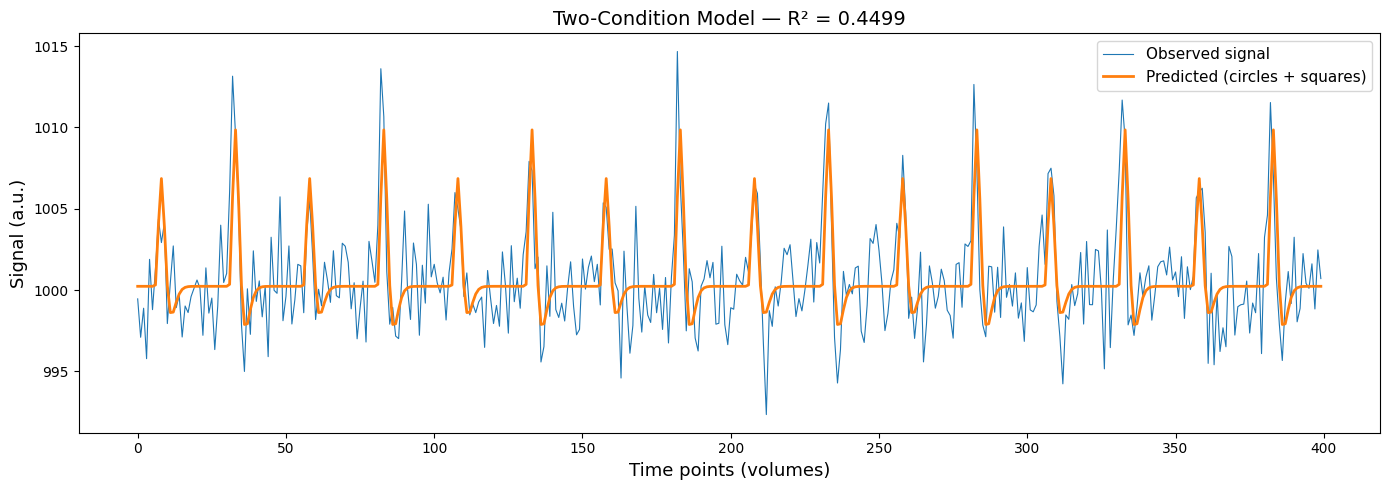

In [ ]:
# Visualise the two-predictor model fit
plt.figure(figsize=(14, 5))
plt.plot(voxel_signal, color="tab:blue", linewidth=0.8, label="Observed signal")
plt.plot(y_hat_sep, color="tab:orange", linewidth=2, label="Predicted (circles + squares)")
plt.xlabel("Time points (volumes)", fontsize=13)
plt.ylabel("Signal (a.u.)", fontsize=13)
plt.title(f"Two-Condition Model — R² = {r2_sep:.4f}", fontsize=14)
plt.legend(fontsize=11)
plt.tight_layout()
plt.show()

The two-condition model yields a higher $R^2$ and lower MSE than the combined model, indicating a better fit to the data. This improvement occurs because allowing each condition its own parameter estimate gives the model more flexibility to capture differences in response amplitude between conditions. The difference between $\hat{\beta}_{\text{circles}}$ and $\hat{\beta}_{\text{squares}}$ directly reflects the estimated difference in BOLD response between the two stimulus types.

### Final Exercise: Building a Convolved Predictor

You conducted an experiment lasting **3 minutes** (180 seconds) with a TR of **3 seconds**. A visual stimulus was presented in six 20-second blocks, starting at $t = 0, 30, 60, 90, 120, 150$ seconds.

**Your tasks:**

1. Create a binary stimulus predictor at seconds resolution (length = 180). Each of the six blocks should be represented as 20 consecutive ones starting at the appropriate onset. Store it in a variable called `ex1_pred`.
2. Convolve this predictor with the canonical HRF (`canonical_hrf`). Trim the result to 180 time points and store it in `ex1_pred_conv`.
3. Resample the convolved predictor to the TR grid (every 3 seconds), giving a vector of 60 values. Store this in `ex1_pred_conv_ds`.

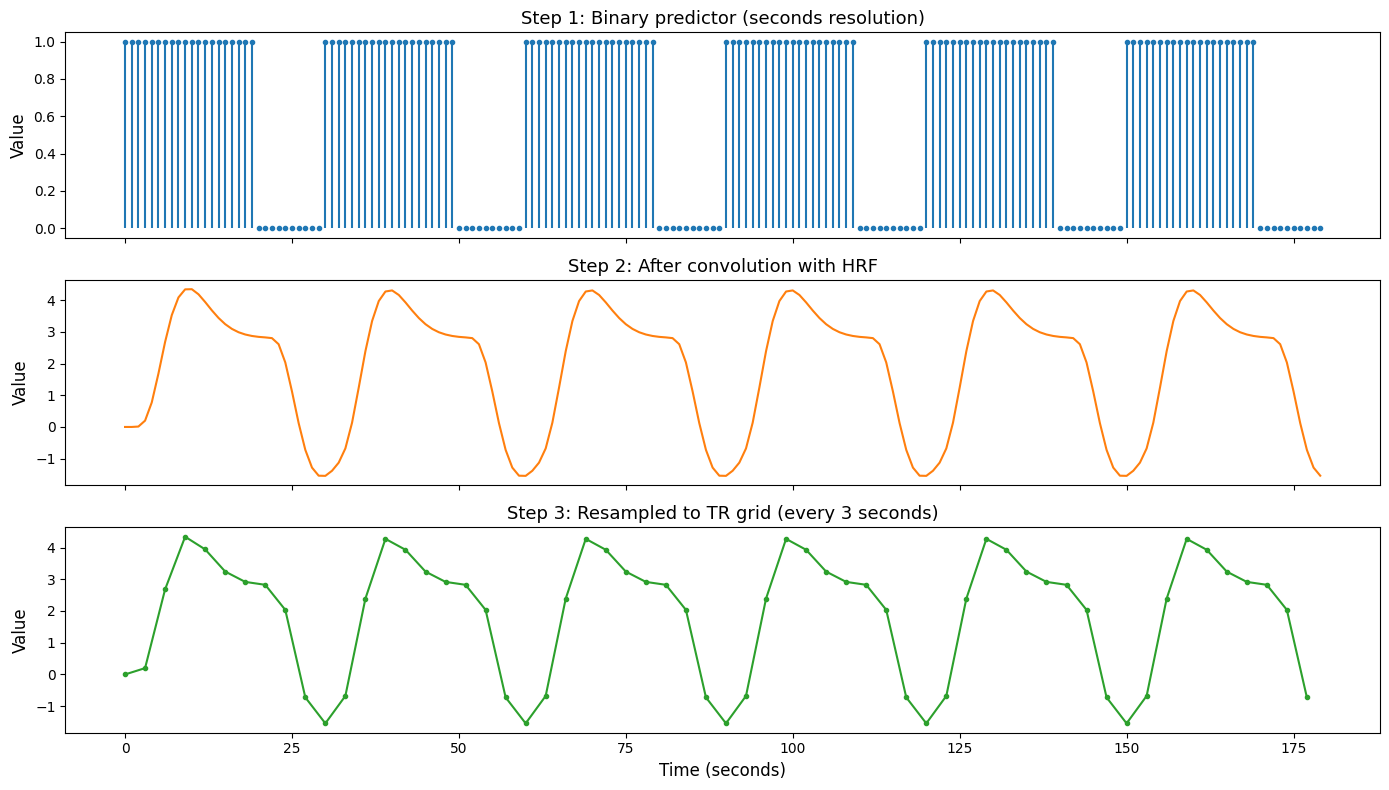

ex1_pred length: 180, sum: 120
ex1_pred_conv length: 180
ex1_pred_conv_ds length: 60


In [ ]:
# Step 1: create binary predictor at seconds resolution
ex1_pred = np.zeros(180, dtype=float)
stim_onsets = [0, 30, 60, 90, 120, 150]
for onset in stim_onsets:
    ex1_pred[onset:onset + 20] = 1

# Step 2: convolve with the HRF and trim
ex1_pred_conv = np.convolve(ex1_pred, canonical_hrf)[:180]

# Step 3: resample to TR grid
original_scale = np.arange(0, 180, 1)
desired_scale = np.arange(0, 180, 3)
resampler = interp1d(original_scale, ex1_pred_conv)
ex1_pred_conv_ds = resampler(desired_scale)

# Quick visual check
fig, axes = plt.subplots(3, 1, figsize=(14, 8), sharex=True)

axes[0].stem(range(180), ex1_pred, basefmt=" ", linefmt="tab:blue", markerfmt=".")
axes[0].set_ylabel("Value", fontsize=12)
axes[0].set_title("Step 1: Binary predictor (seconds resolution)", fontsize=13)

axes[1].plot(ex1_pred_conv, color="tab:orange", linewidth=1.5)
axes[1].set_ylabel("Value", fontsize=12)
axes[1].set_title("Step 2: After convolution with HRF", fontsize=13)

axes[2].plot(desired_scale, ex1_pred_conv_ds, color="tab:green", linewidth=1.5, marker="o", markersize=3)
axes[2].set_ylabel("Value", fontsize=12)
axes[2].set_xlabel("Time (seconds)", fontsize=12)
axes[2].set_title("Step 3: Resampled to TR grid (every 3 seconds)", fontsize=13)

plt.tight_layout()
plt.show()

print(f"ex1_pred length: {ex1_pred.size}, sum: {ex1_pred.sum():.0f}")
print(f"ex1_pred_conv length: {ex1_pred_conv.size}")
print(f"ex1_pred_conv_ds length: {ex1_pred_conv_ds.size}")

### Exercise 2: Multi-Condition Predictors

A colleague ran an fMRI experiment lasting **600 seconds** with a TR of **2.5 seconds** (yielding 240 volumes). The experiment contained two conditions:

- **Faces** were presented at $t = 20, 80, 140, 260, 380, 500$ seconds (brief events).
- **Houses** were presented in 10-second blocks starting at $t = 50, 170, 290, 350, 440, 530$ seconds.

**Your tasks:**

1. Create two binary predictors at seconds resolution (length = 600): one for faces (impulses at each onset) and one for houses (10 consecutive ones per block). Store these in `ex2_faces` and `ex2_houses`.
2. Convolve each predictor with the canonical HRF and trim the result to 600 time points. Store these in `ex2_faces_conv` and `ex2_houses_conv`.
3. Resample both convolved predictors to the TR grid (every 2.5 seconds), giving vectors of 240 values each. Store these in `ex2_faces_ds` and `ex2_houses_ds`.
4. Plot both resampled convolved predictors on the same figure, so that the difference in shape between event-related and block designs is clearly visible.

*Hint: The house blocks follow the same logic as the blocks in Exercise 1 — for each onset, set the following 10 time points to 1.*

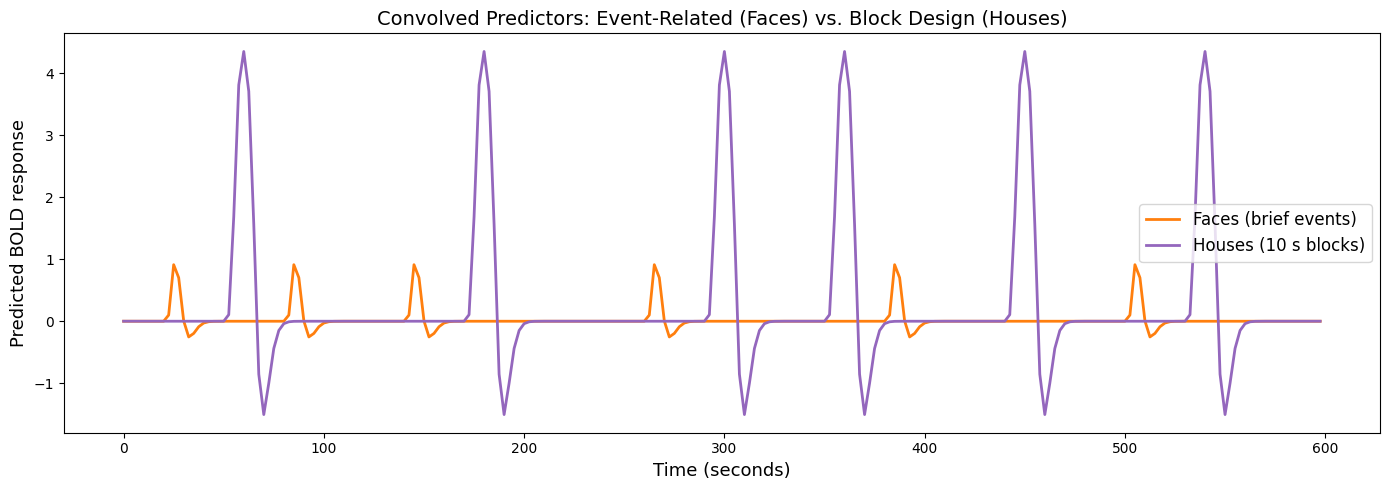

ex2_faces: length = 600, sum = 6
ex2_houses: length = 600, sum = 60
ex2_faces_ds: length = 240
ex2_houses_ds: length = 240


In [ ]:
# Step 1: create binary predictors at seconds resolution
ex2_faces = np.zeros(600)
face_onsets = [20, 80, 140, 260, 380, 500]
ex2_faces[face_onsets] = 1

ex2_houses = np.zeros(600)
house_onsets = [50, 170, 290, 350, 440, 530]
for onset in house_onsets:
    ex2_houses[onset:onset + 10] = 1

# Step 2: convolve each with the HRF and trim
ex2_faces_conv = np.convolve(ex2_faces, canonical_hrf)[:600]
ex2_houses_conv = np.convolve(ex2_houses, canonical_hrf)[:600]

# Step 3: resample to TR grid (every 2.5 seconds)
original_scale = np.arange(0, 600, 1)
desired_scale = np.arange(0, 600, 2.5)
ex2_faces_ds = interp1d(original_scale, ex2_faces_conv)(desired_scale)
ex2_houses_ds = interp1d(original_scale, ex2_houses_conv)(desired_scale)

# Step 4: plot both convolved, resampled predictors
time_axis = desired_scale  # in seconds

plt.figure(figsize=(14, 5))
plt.plot(time_axis, ex2_faces_ds, color="tab:orange", linewidth=2, label="Faces (brief events)")
plt.plot(time_axis, ex2_houses_ds, color="tab:purple", linewidth=2, label="Houses (10 s blocks)")
plt.xlabel("Time (seconds)", fontsize=13)
plt.ylabel("Predicted BOLD response", fontsize=13)
plt.title("Convolved Predictors: Event-Related (Faces) vs. Block Design (Houses)", fontsize=14)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

print(f"ex2_faces: length = {ex2_faces.size}, sum = {ex2_faces.sum():.0f}")
print(f"ex2_houses: length = {ex2_houses.size}, sum = {ex2_houses.sum():.0f}")
print(f"ex2_faces_ds: length = {ex2_faces_ds.size}")
print(f"ex2_houses_ds: length = {ex2_houses_ds.size}")

**Bonus Question 2b:** Examine the plot you created above. How do the convolved face predictors (brief events) differ in shape from the convolved house predictors (10-second blocks)? In one or two sentences, explain why convolution with the same HRF produces such different waveforms for these two conditions.

**Answer**: The face predictors produce narrow, sharply peaked waveforms because each brief event is convolved with a single copy of the HRF, yielding an isolated rise-and-fall response. The house predictors, by contrast, produce broader and more sustained waveforms with higher amplitude, because convolution effectively stamps an HRF at every second that the stimulus is present; these overlapping responses sum together (linear superposition), resulting in a prolonged plateau that reflects the extended duration of each block.

### Exercise 3: Interpretation

Answer the following questions based on the model fitting demonstrations (Sections 1.6 and 1.7). If needed, scroll back up and re-run those cells to review the output. Write your answers in the markdown cells below.

**Question 3a**: In the two-condition model (Section 1.7), the GLM estimated separate $\hat{\beta}$ values for circles and squares. Using those parameter estimates and the intercept, compute the **percent signal change** for each condition (i.e., $\hat{\beta}_{\text{condition}} / \hat{\beta}_{\text{intercept}} \times 100$). What do these values tell you about this voxel's response to the two stimulus types?

**Question 3b:** Compare the single-predictor model (all stimuli combined, Section 1.6) and a two-predictor model (circles and squares separated, Section 1.7). Why does the two-condition model produce a better fit? What does this improvement imply about the voxel's functional properties?

**Question 3c:** Even the best model explained only about 40–45% of the variance in the voxel signal. Identify at least two sources of variance that the GLM does *not* capture, and explain why you would expect single-voxel $R^2$ values in fMRI to be substantially lower than in typical behavioural experiments.

**Answer 3a:** The response to circles is larger than the response to squares, suggesting that the voxel is located in a region that is more strongly engaged by circle stimuli.

**Answer 3b:** The two-condition model produces a better fit because it allows the GLM to estimate a separate response amplitude for each stimulus type. When both conditions are collapsed into a single predictor, the model is forced to assign one $\beta$ value that represents an average response across circles and squares. If the voxel responds differently to the two conditions, this averaged predictor cannot accurately capture the signal during either condition - it overestimates the response during square trials and underestimates it during circle trials. By separating the conditions, each predictor can be scaled independently, yielding predictions that more closely track the observed time series. The improvement in $R^2$ therefore implies that this voxel distinguishes between circles and squares.

**Answer 3c:** At least two major sources of variance remain unmodelled. First, **physiological noise** — including cardiac pulsation, respiratory cycles, etc — introduces signal variations that are unrelated to the experimental design and not captured by task-based predictors. Second, **scanner-related noise**, such as thermal noise, low-frequency signal drift over the course of the session, and head motion artefacts, contributes additional variance that the GLM does not account for (though some of these can be addressed by adding nuisance regressors, which is covered in later sessions).
Single-voxel $R^2$ values in fMRI are expected to be substantially lower than in behavioural experiments because the BOLD signal is an indirect, noisy measure of neural activity. The haemodynamic coupling introduces temporal blurring, physiological processes generate substantial background fluctuations, and the stimulus-evoked signal change is typically less than 1–2% of the baseline signal. In behavioural experiments, by contrast, the dependent variable (e.g., reaction time) is often more directly linked to the manipulation, and noise sources are typically less dominant relative to the effect size.